<a href="https://colab.research.google.com/github/Kaamraan19064/OPD/blob/master/gan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from torchvision.utils import save_image
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np
from sklearn import svm
import sklearn.model_selection
import sklearn.metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from sklearn.ensemble import VotingClassifier
import math 
import tensorflow as tf

In [0]:
# bs =64
# # MNIST Dataset
# train_dataset = datasets.MNIST(root='./mnist_data/', train=True, transform=transforms.ToTensor(), download=True)
# test_dataset = datasets.MNIST(root='./mnist_data/', train=False, transform=transforms.ToTensor(), download=False)
# # print(len(train_dataset))
# # print(len(test_dataset))
# # print(type(train_dataset))
# # Data Loader (Input Pipeline)
# train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=bs, shuffle=True)
# test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=bs, shuffle=False)
# print(len(train_loader))
# print(len(test_loader))

938
157


In [0]:
def mnist_data():
    compose = transforms.Compose(
        [
            transforms.Resize(64),
            transforms.ToTensor(),
            transforms.Normalize((.5,), (.5,))
        ])
    out_dir = '{}/dataset'.format(DATA_FOLDER)
    return datasets.MNIST(root=out_dir, train=True, transform=compose, download=True)

In [0]:
DATA_FOLDER = './torch_data/DCGAN/MNIST'
data = mnist_data()
batch_size = 100
train_loader = torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=True)
num_batches = len(train_loader)

In [0]:
# def triplet():
#   bs =1
#   train_dataset = datasets.MNIST(root='./mnist_data/', train=True, transform=transforms.ToTensor(), download=True)
#   train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=bs, shuffle=False)
#   for img,lab in train_loader:
#     if (lab==5):
#       print("yup")
#     print(lab)
#     break
# triplet()

yup
tensor([5])


In [0]:
class DiscriminativeNet(torch.nn.Module):
    
    def __init__(self):
        super(DiscriminativeNet, self).__init__()
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels=1, out_channels=128, kernel_size=4, 
                stride=2, padding=1, bias=False
            ),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(
                in_channels=128, out_channels=256, kernel_size=4,
                stride=2, padding=1, bias=False
            ),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(
                in_channels=256, out_channels=512, kernel_size=4,
                stride=2, padding=1, bias=False
            ),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(
                in_channels=512, out_channels=1024, kernel_size=4,
                stride=2, padding=1, bias=False
            ),
            nn.BatchNorm2d(1024),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.out = nn.Sequential(
            nn.Linear(1024*4*4, 16),
            # nn.Sigmoid(),
        )

    def forward(self, x):
        # Convolutional layers
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        # Flatten and apply sigmoid
        x = x.view(-1, 1024*4*4)
        x = self.out(x)
        # print(x)
        return x

In [0]:
class GenerativeNet(torch.nn.Module):
    
    def __init__(self):
        super(GenerativeNet, self).__init__()
        
        self.linear = torch.nn.Linear(100, 1024*4*4)
        
        self.conv1 = nn.Sequential(
            nn.ConvTranspose2d(
                in_channels=1024, out_channels=512, kernel_size=4,
                stride=2, padding=1, bias=False
            ),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True)
        )
        self.conv2 = nn.Sequential(
            nn.ConvTranspose2d(
                in_channels=512, out_channels=256, kernel_size=4,
                stride=2, padding=1, bias=False
            ),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )
        self.conv3 = nn.Sequential(
            nn.ConvTranspose2d(
                in_channels=256, out_channels=128, kernel_size=4,
                stride=2, padding=1, bias=False
            ),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True)
        )
        self.conv4 = nn.Sequential(
            nn.ConvTranspose2d(
                in_channels=128, out_channels=1, kernel_size=4,
                stride=2, padding=1, bias=False
            )
        )
        self.out = torch.nn.Tanh()

    def forward(self, x):
        # Project and reshape
        x = self.linear(x)
        x = x.view(x.shape[0], 1024, 4, 4)
        # Convolutional layers
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        # Apply Tanh
        return self.out(x)
    
# Noise
def noise(size):
    n = Variable(torch.randn(size, 100))
    # n=torch.randn(size, 100)
    if torch.cuda.is_available(): return n.cuda()
    return n

In [0]:
def init_weights(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1 or classname.find('BatchNorm') != -1:
        m.weight.data.normal_(0.00, 0.02)

In [313]:

# Create Network instances and init weights
generator = GenerativeNet()
generator.apply(init_weights)

discriminator = DiscriminativeNet()
discriminator.apply(init_weights)
# discriminator = Discriminator()

# Enable cuda if available
if torch.cuda.is_available():
    generator.cuda()
    discriminator.cuda()
    print("avail")

avail


In [0]:
# Optimizers
from torch.optim import Adam
d_optimizer = Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))
g_optimizer = Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))

# Loss function
loss = nn.BCELoss()
# Number of epochs
num_epochs = 50

In [0]:
def real_data_target(size):
    '''
    Tensor containing ones, with shape = size
    '''
    data = Variable(torch.ones(size, 1))
    if torch.cuda.is_available(): return data.cuda()
    return data

def fake_data_target(size):
    '''
    Tensor containing zeros, with shape = size
    '''
    data = Variable(torch.zeros(size, 1))
    if torch.cuda.is_available(): return data.cuda()
    return data
def prob_real(prediction_real):
  t=torch.exp(prediction_real)
  t=torch.sum(t,axis = 1)
  t1=t+1
  t=t/t1
  return t.cuda()

def prob_fake(prediction_real):
  t=torch.exp(prediction_real)
  t=torch.sum(t,axis = 1)
  t1=t+1
  t=t/t1
  t=1-t
  return t.cuda()


In [0]:
def train_discriminator(optimizer, real_data, fake_data):
    optimizer.zero_grad()
    
    # 1. Train on Real Data
    prediction_real = discriminator(real_data)
    prediction_real=prob_real(prediction_real)
    error_real = loss(prediction_real, real_data_target(real_data.size(0)))
    error_real.backward()

    # 2. Train on Fake Data
    prediction_fake = discriminator(fake_data)
    prediction_fake=prob_fake(prediction_fake).detach()
    prediction_fake = Variable(prediction_fake, requires_grad=True)
    error_fake = loss(prediction_fake, fake_data_target(real_data.size(0)))
    error_fake.backward()

    optimizer.step()
    return error_real + error_fake, prediction_real, prediction_fake

def train_generator(optimizer, fake_data):
    optimizer.zero_grad()
    prediction = discriminator(fake_data)
    prediction=prob_fake(prediction)
    error = loss(prediction, real_data_target(prediction.size(0)))
    error.backward()
    optimizer.step()
    return error

In [0]:
num_test_samples = 16
test_noise = noise(num_test_samples)

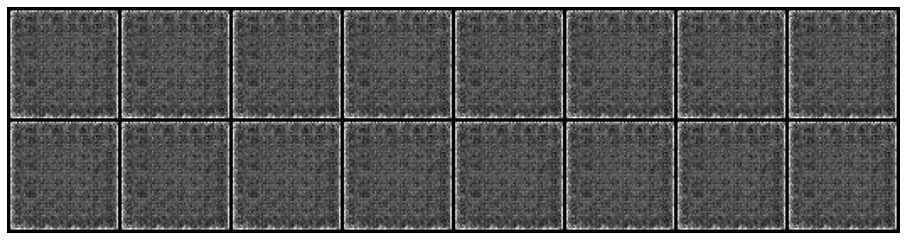

Epoch: [1/50], Batch Num: [200/600]
Discriminator Loss: 0.4590, Generator Loss: 0.9998
D(x): 1.0000, D(G(z)): 0.3681


In [0]:

for epoch in range(num_epochs):
    for n_batch, (real_batch,_) in enumerate(train_loader):
        
        # 1. Train Discriminator
        real_data = Variable(real_batch)
        # print(type(real_batch))
        # print(real_batch)
        if torch.cuda.is_available():
          # print("avail")
          real_data = real_data.cuda()
        # Generate fake data
        fake_data = generator(noise(real_data.size(0))).detach()
        d_error, d_pred_real, d_pred_fake = train_discriminator(d_optimizer, real_data, fake_data)
        fake_data = generator(noise(real_batch.size(0)))
        g_error = train_generator(g_optimizer, fake_data)

        if (n_batch) % 100 == 0:
          display.clear_output(True)
          generator.eval()
          images = generator(test_noise).data.cpu()
          horizontal_grid = vutils.make_grid(
          images, normalize=True, scale_each=True)
          fig = plt.figure(figsize=(16, 16))
          plt.imshow(np.moveaxis(horizontal_grid.numpy(), 0, -1))
          plt.axis('off')
          display.display(plt.gcf())
          plt.close()
          generator.train()
          print('Epoch: [{}/{}], Batch Num: [{}/{}]'.format(epoch,num_epochs, n_batch, num_batches))
          print('Discriminator Loss: {:.4f}, Generator Loss: {:.4f}'.format(d_error, g_error))
          print('D(x): {:.4f}, D(G(z)): {:.4f}'.format(d_pred_real.mean(), d_pred_fake.mean()))

    torch.save(discriminator.state_dict(),'/content/drive/My Drive/Colab Notebooks/DL_ENDSEM/dis.pth')
    torch.save(generator.state_dict(),'/content/drive/My Drive/Colab Notebooks/DL_ENDSEM/gen.pth')

In [0]:
Wasteeee!!!

In [0]:
# from utils import Logger
logger = Logger(model_name='DCGAN', data_name='MNIST')
print(type(train_loader))
for epoch in range(num_epochs):
    for n_batch, (real_batch,_) in enumerate(train_loader):
        
        # 1. Train Discriminator
        real_data = Variable(real_batch)
        # print(type(real_batch))
        # print(real_batch)
        if torch.cuda.is_available():
          # print("avail")
          real_data = real_data.cuda()
        # Generate fake data
        fake_data = generator(noise(real_data.size(0))).detach()
        # Train D
        d_error, d_pred_real, d_pred_fake = train_discriminator(d_optimizer, 
                                                                real_data, fake_data)

        # 2. Train Generator
        # Generate fake data
        fake_data = generator(noise(real_batch.size(0)))
        # Train G
        g_error = train_generator(g_optimizer, fake_data)
        # Log error
        print()
        logger.log(d_error, g_error, epoch, n_batch, num_batches)
        
        # Display Progress
        if (n_batch) % 100 == 0:
          display.clear_output(True)
                  # Display Images
          test_images = generator(test_noise).data.cpu()
          logger.log_images(test_images, num_test_samples, epoch, n_batch, num_batches);
          # Display status Logs
          logger.display_status(
              epoch, num_epochs, n_batch, num_batches,
              d_error, g_error, d_pred_real, d_pred_fake
          )
      # Model Checkpoints
    logger.save_models(generator, discriminator, epoch)
    torch.save(discriminator.state_dict(),'/content/drive/My Drive/Colab Notebooks/DL_ENDSEM/dis.pth')
    torch.save(generator.state_dict(),'/content/drive/My Drive/Colab Notebooks/DL_ENDSEM/gen.pth')


In [0]:
!pip3 install tensorboardX
import os
import numpy as np
import errno
import torchvision.utils as vutils
from tensorboardX import SummaryWriter
from IPython import display
from matplotlib import pyplot as plt
import torch

'''
    TensorBoard Data will be stored in './runs' path
'''


class Logger:

    def __init__(self, model_name, data_name):
        self.model_name = model_name
        self.data_name = data_name

        self.comment = '{}_{}'.format(model_name, data_name)
        self.data_subdir = '{}/{}'.format(model_name, data_name)

        # TensorBoard
        self.writer = SummaryWriter(comment=self.comment)

    def log(self, d_error, g_error, epoch, n_batch, num_batches):

        # var_class = torch.autograd.variable.Variable
        if isinstance(d_error, torch.autograd.Variable):
            d_error = d_error.data.cpu().numpy()
        if isinstance(g_error, torch.autograd.Variable):
            g_error = g_error.data.cpu().numpy()

        step = Logger._step(epoch, n_batch, num_batches)
        self.writer.add_scalar(
            '{}/D_error'.format(self.comment), d_error, step)
        self.writer.add_scalar(
            '{}/G_error'.format(self.comment), g_error, step)

    def log_images(self, images, num_images, epoch, n_batch, num_batches, format='NCHW', normalize=True):
        '''
        input images are expected in format (NCHW)
        '''
        if type(images) == np.ndarray:
            images = torch.from_numpy(images)
        
        if format=='NHWC':
            images = images.transpose(1,3)
        

        step = Logger._step(epoch, n_batch, num_batches)
        img_name = '{}/images{}'.format(self.comment, '')

        # Make horizontal grid from image tensor
        horizontal_grid = vutils.make_grid(
            images, normalize=normalize, scale_each=True)
        # Make vertical grid from image tensor
        nrows = int(np.sqrt(num_images))
        grid = vutils.make_grid(
            images, nrow=nrows, normalize=True, scale_each=True)

        # Add horizontal images to tensorboard
        self.writer.add_image(img_name, horizontal_grid, step)

        # Save plots
        self.save_torch_images(horizontal_grid, grid, epoch, n_batch)

    def save_torch_images(self, horizontal_grid, grid, epoch, n_batch, plot_horizontal=True):
        out_dir = './data/images/{}'.format(self.data_subdir)
        Logger._make_dir(out_dir)

        # Plot and save horizontal
        fig = plt.figure(figsize=(16, 16))
        plt.imshow(np.moveaxis(horizontal_grid.numpy(), 0, -1))
        plt.axis('off')
        if plot_horizontal:
            display.display(plt.gcf())
        self._save_images(fig, epoch, n_batch, 'hori')
        plt.close()

        # Save squared
        fig = plt.figure()
        plt.imshow(np.moveaxis(grid.numpy(), 0, -1))
        plt.axis('off')
        self._save_images(fig, epoch, n_batch)
        plt.close()

    def _save_images(self, fig, epoch, n_batch, comment=''):
        out_dir = './data/images/{}'.format(self.data_subdir)
        Logger._make_dir(out_dir)
        fig.savefig('{}/{}_epoch_{}_batch_{}.png'.format(out_dir,
                                                         comment, epoch, n_batch))

    def display_status(self, epoch, num_epochs, n_batch, num_batches, d_error, g_error, d_pred_real, d_pred_fake):
        
        # var_class = torch.autograd.variable.Variable
        if isinstance(d_error, torch.autograd.Variable):
            d_error = d_error.data.cpu().numpy()
        if isinstance(g_error, torch.autograd.Variable):
            g_error = g_error.data.cpu().numpy()
        if isinstance(d_pred_real, torch.autograd.Variable):
            d_pred_real = d_pred_real.data
        if isinstance(d_pred_fake, torch.autograd.Variable):
            d_pred_fake = d_pred_fake.data
        
        
        print('Epoch: [{}/{}], Batch Num: [{}/{}]'.format(
            epoch,num_epochs, n_batch, num_batches)
             )
        print('Discriminator Loss: {:.4f}, Generator Loss: {:.4f}'.format(d_error, g_error))
        print('D(x): {:.4f}, D(G(z)): {:.4f}'.format(d_pred_real.mean(), d_pred_fake.mean()))

    def save_models(self, generator, discriminator, epoch):
        out_dir = './data/models/{}'.format(self.data_subdir)
        Logger._make_dir(out_dir)
        torch.save(generator.state_dict(),
                   '{}/G_epoch_{}'.format(out_dir, epoch))
        torch.save(discriminator.state_dict(),
                   '{}/D_epoch_{}'.format(out_dir, epoch))

    def close(self):
        self.writer.close()

    # Private Functionality

    @staticmethod
    def _step(epoch, n_batch, num_batches):
        return epoch * num_batches + n_batch

    @staticmethod
    def _make_dir(directory):
        try:
            os.makedirs(directory)
        except OSError as e:
            if e.errno != errno.EEXIST:
                raise

     |████████████████████████████████| 204kB 4.8MB/s 


In [0]:

import torch.nn as nn
import torch.nn.functional as F

class Discriminator(nn.Module):

    def __init__(self, input_size, hidden_dim1,hidden_dim2,hidden_dim3):
        super(Discriminator, self).__init__()
        
        # define hidden linear layers
        self.fc1 = nn.Linear(input_size, hidden_dim1)
        self.fc2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.fc3 = nn.Linear(hidden_dim2, hidden_dim3)
        self.fc4 = nn.Linear(hidden_dim3, hidden_dim3)
        self.fc5 = nn.Linear(hidden_dim3, 16)
        
        # final fully-connected layer
        # self.fc4 = nn.Linear(hidden_dim, output_size)
        
        # dropout layer 
        self.dropout = nn.Dropout(0.3)
        
        
    def forward(self, x):
        # flatten image
        x = x.view(-1, 28*28)
        # all hidden layers
        x = F.leaky_relu(self.fc1(x), 0.2) # (input, negative_slope=0.2)
        # x = self.dropout(x)
        x = F.leaky_relu(self.fc2(x), 0.2)
        # x = self.dropout(x)
        x = F.leaky_relu(self.fc3(x),0.2)
        x = F.leaky_relu(self.fc4(x),0.2)
        x = self.fc5(x)
        # x = self.dropout(x)
        # # final layer
        # out = self.fc4(x)

        return x

In [0]:
class Generator(nn.Module):

    def __init__(self, input_size, hidden_dim1):
        super(Generator, self).__init__()
        
        # define hidden linear layers
        # self.fc1 = nn.Linear(input_size, hidden_dim)
        # self.fc2 = nn.Linear(hidden_dim, hidden_dim*2)
        # self.fc3 = nn.Linear(hidden_dim*2, hidden_dim*4)
        self.fc1 = nn.Linear(input_size, hidden_dim1)
        self.fc2 = nn.Linear(hidden_dim1, hidden_dim1)
        self.fc3 = nn.Linear(hidden_dim1, 784)
        # final fully-connected layer
        # self.fc4 = nn.Linear(hidden_dim*4, output_size)
        
        # dropout layer 
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        # all hidden layers
        x = F.leaky_relu(self.fc1(x), 0.2) # (input, negative_slope=0.2)
        # x = self.dropout(x)
        x = F.leaky_relu(self.fc2(x), 0.2)
        # x = self.dropout(x)
        x = F.tanh(self.fc3(x))
        # x = self.dropout(x)
        # # final layer with tanh applied
        # out = F.tanh(self.fc4(x))

        return x

In [0]:
# Discriminator hyperparams

# Size of input image to discriminator (28*28)
input_size = 784
# Size of discriminator output (real or fake)
d_output_size = 16
# Size of last hidden layer in the discriminator
d_hidden_size1 = 1000
d_hidden_size2 = 500
d_hidden_size3 = 250

# Generator hyperparams

# Size of latent vector to give to generator
# z_size = 100
z_size=100
# Size of discriminator output (generated image)
g_output_size = 784
# Size of first hidden layer in the generator
g_hidden_size = 500


In [0]:
D = Discriminator(input_size, d_hidden_size1,d_hidden_size2,d_hidden_size3)
G = Generator(z_size, g_hidden_size)
print(D)
print()
print(G)

Discriminator(
  (fc1): Linear(in_features=784, out_features=1000, bias=True)
  (fc2): Linear(in_features=1000, out_features=500, bias=True)
  (fc3): Linear(in_features=500, out_features=250, bias=True)
  (fc4): Linear(in_features=250, out_features=250, bias=True)
  (fc5): Linear(in_features=250, out_features=16, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)

Generator(
  (fc1): Linear(in_features=100, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=500, bias=True)
  (fc3): Linear(in_features=500, out_features=784, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)


In [0]:
# Calculate losses
def real_loss(D_out, smooth=False):
    batch_size = D_out.size(0)
    # label smoothing
    if smooth:
        # smooth, real labels = 0.9
        labels = torch.ones(batch_size)*0.9
    else:
        labels = torch.ones(batch_size) # real labels = 1
        
    # numerically stable loss
    criterion = nn.BCEWithLogitsLoss()
    # calculate loss
    loss = criterion(D_out.squeeze(), labels)
    return loss

def fake_loss(D_out):
    batch_size = D_out.size(0)
    labels = torch.zeros(batch_size) # fake labels = 0
    criterion = nn.BCEWithLogitsLoss()
    # calculate loss
    loss = criterion(D_out.squeeze(), labels)
    return loss

def prob_real(prediction_real):
  b=prediction_real.cpu().detach().numpy()
  out_array = np.exp(b)
  arr1= np.sum(out_array, axis = 1)
  # print(arr1)
  arr2=arr1+1
  out_array = np.divide(arr1, arr2)
  # print(out_array)
  tensor = torch.from_numpy(out_array).cuda()
  return tensor

def prob_fake(prediction_real):
  b=prediction_real.cpu().detach().numpy()
  out_array = np.exp(b)
  arr1= np.sum(out_array, axis = 1)
  # print(arr1,"f")
  arr2=arr1+1
  out_array = np.divide(arr1, arr2)
  out_array=1-out_array
  # print(out_array,"fake")
  tensor = torch.from_numpy(out_array).cuda()
  return tensor


In [0]:
import torch.optim as optim

# Optimizers
lr = 0.002

# Create optimizers for the discriminator and generator
d_optimizer = optim.Adam(D.parameters(), lr)
g_optimizer = optim.Adam(G.parameters(), lr)

In [0]:
import pickle as pkl

# training hyperparams
num_epochs = 100

# keep track of loss and generated, "fake" samples
samples = []
losses = []

print_every = 400

# Get some fixed data for sampling. These are images that are held
# constant throughout training, and allow us to inspect the model's performance
sample_size=16
fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
fixed_z = torch.from_numpy(fixed_z).float()

# train the network
D.train()
G.train()
for epoch in range(num_epochs):
    
    for batch_i, (real_images, _) in enumerate(train_loader):
                
        batch_size = real_images.size(0)
        
        ## Important rescaling step ## 
        real_images = real_images*2 - 1  # rescale input images from [0,1) to [-1, 1)
        
        # ============================================
        #            TRAIN THE DISCRIMINATOR
        # ============================================
        
        d_optimizer.zero_grad()
        
        # 1. Train with real images

        # Compute the discriminator losses on real images 
        # smooth the real labels
        D_real = D(real_images)
        D_real=prob_real(D_real).cpu()
        D_real = Variable(D_real.data, requires_grad=True)
        d_real_loss = real_loss(D_real, smooth=True)
        
        # 2. Train with fake images
        
        # Generate fake images
        z = np.random.uniform(-1, 1, size=(batch_size, z_size))
        z = torch.from_numpy(z).float()
        fake_images = G(z)
        
        # Compute the discriminator losses on fake images        
        D_fake = D(fake_images)
        D_fake=prob_fake(D_fake).cpu()
        D_fake = Variable(D_fake.data, requires_grad=True)
        d_fake_loss = fake_loss(D_fake)
        
        # add up loss and perform backprop
        d_loss = d_real_loss + d_fake_loss
        d_loss.backward()
        d_optimizer.step()
        
        
        # =========================================
        #            TRAIN THE GENERATOR
        # =========================================
        g_optimizer.zero_grad()
        
        # 1. Train with fake images and flipped labels
        
        # Generate fake images
        z = np.random.uniform(-1, 1, size=(batch_size, z_size))
        z = torch.from_numpy(z).float()
        fake_images = G(z)
        
        # Compute the discriminator losses on fake images 
        # using flipped labels!
        D_fake = D(fake_images)
        D_fake=prob_fake(D_fake).cpu()
        D_fake = Variable(D_fake.data, requires_grad=True)
        g_loss = real_loss(D_fake) # use real loss to flip labels
        
        # perform backprop
        g_loss.backward()
        g_optimizer.step()

        # Print some loss stats
        if batch_i % print_every == 0:
            # print discriminator and generator loss
            print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                    epoch+1, num_epochs, d_loss.item(), g_loss.item()))

    
    ## AFTER EACH EPOCH##
    # append discriminator loss and generator loss
    losses.append((d_loss.item(), g_loss.item()))
    
    # generate and save sample, fake images
    G.eval() # eval mode for generating samples
    samples_z = G(fixed_z)
    samples.append(samples_z)
    G.train() # back to train mode


# Save training generator samples
with open('train_samples.pkl', 'wb') as f:
    pkl.dump(samples, f)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1558: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch [    1/  100] | d_loss: 1.1472 | g_loss: 0.6637
Epoch [    1/  100] | d_loss: 1.1472 | g_loss: 0.6637
Epoch [    1/  100] | d_loss: 1.1472 | g_loss: 0.6637
Epoch [    2/  100] | d_loss: 1.1472 | g_loss: 0.6637
Epoch [    2/  100] | d_loss: 1.1472 | g_loss: 0.6637
Epoch [    2/  100] | d_loss: 1.1472 | g_loss: 0.6637
Epoch [    3/  100] | d_loss: 1.1472 | g_loss: 0.6637
Epoch [    3/  100] | d_loss: 1.1472 | g_loss: 0.6637
Epoch [    3/  100] | d_loss: 1.1472 | g_loss: 0.6637
Epoch [    4/  100] | d_loss: 1.1472 | g_loss: 0.6637
Epoch [    4/  100] | d_loss: 1.1472 | g_loss: 0.6637
Epoch [    4/  100] | d_loss: 1.1472 | g_loss: 0.6637
Epoch [    5/  100] | d_loss: 1.1472 | g_loss: 0.6637
Epoch [    5/  100] | d_loss: 1.1472 | g_loss: 0.6637
Epoch [    5/  100] | d_loss: 1.1472 | g_loss: 0.6637
Epoch [    6/  100] | d_loss: 1.1472 | g_loss: 0.6637
Epoch [    6/  100] | d_loss: 1.1472 | g_loss: 0.6637
Epoch [    6/  100] | d_loss: 1.1472 | g_loss: 0.6637
Epoch [    7/  100] | d_loss

/usr/local/lib/python3.6/dist-packages/torch/storage.py:34: FutureWarning: pickle support for Storage will be removed in 1.5. Use `torch.save` instead
  warnings.warn("pickle support for Storage will be removed in 1.5. Use `torch.save` instead", FutureWarning)


In [0]:
with open('train_samples.pkl', 'wb') as f:
    pkl.dump(samples, f)

In [0]:

# helper function for viewing a list of passed in sample images
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(7,7), nrows=4, ncols=4, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach()
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((28,28)), cmap='Greys_r')

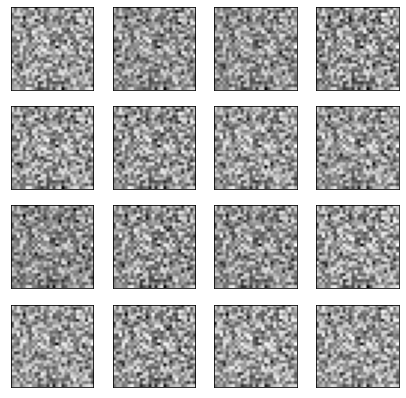

In [0]:
view_samples(-1, samples)

In [0]:
import os
import torch
import torchvision
import torch.nn as nn
from torchvision import transforms
from torchvision.utils import save_image
from torch.autograd import Variable
import matplotlib.pyplot as plt
import pylab
import numpy as np

# Hyper-parameters
latent_size = 64
hidden_size = 256
image_size = 784
num_epochs = 300
batch_size = 32
sample_dir = 'samples'
save_dir = 'save'

# Create a directory if not exists
if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)

if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# Image processing
transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize(mean=(0.5, 0.5, 0.5),   # 3 for RGB channels
                                     std=(0.5, 0.5, 0.5))])

# MNIST dataset
mnist = torchvision.datasets.MNIST(root='./data/',
                                   train=True,
                                   transform=transform,
                                   download=True)

# Data loader
data_loader = torch.utils.data.DataLoader(dataset=mnist,
                                          batch_size=batch_size, 
                                          shuffle=True)

# Discriminator
D = nn.Sequential(
    nn.Linear(image_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, 1),
    nn.Sigmoid())

# Generator 
G = nn.Sequential(
    nn.Linear(latent_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, image_size),
    nn.Tanh())

# Device setting
D = D.cuda()
G = G.cuda()

# Binary cross entropy loss and optimizer
criterion = nn.BCELoss()
d_optimizer = torch.optim.Adam(D.parameters(), lr=0.0002)
g_optimizer = torch.optim.Adam(G.parameters(), lr=0.0002)

def denorm(x):
    out = (x + 1) / 2
    return out.clamp(0, 1)

def reset_grad():
    d_optimizer.zero_grad()
    g_optimizer.zero_grad()

# Statistics to be saved
d_losses = np.zeros(num_epochs)
g_losses = np.zeros(num_epochs)
real_scores = np.zeros(num_epochs)
fake_scores = np.zeros(num_epochs)

# Start training
total_step = len(data_loader)
for epoch in range(num_epochs):
    for i, (images, _) in enumerate(data_loader):
        images = images.view(batch_size, -1).cuda()
        images = Variable(images)
        # Create the labels which are later used as input for the BCE loss
        real_labels = torch.ones(batch_size, 1).cuda()
        real_labels = Variable(real_labels)
        fake_labels = torch.zeros(batch_size, 1).cuda()
        fake_labels = Variable(fake_labels)

        # ================================================================== #
        #                      Train the discriminator                       #
        # ================================================================== #

        # Compute BCE_Loss using real images where BCE_Loss(x, y): - y * log(D(x)) - (1-y) * log(1 - D(x))
        # Second term of the loss is always zero since real_labels == 1
        outputs = D(images)
        d_loss_real = criterion(outputs, real_labels)
        real_score = outputs
        
        # Compute BCELoss using fake images
        # First term of the loss is always zero since fake_labels == 0
        z = torch.randn(batch_size, latent_size).cuda()
        z = Variable(z)
        fake_images = G(z)
        outputs = D(fake_images)
        d_loss_fake = criterion(outputs, fake_labels)
        fake_score = outputs
        
        # Backprop and optimize
        # If D is trained so well, then don't update
        d_loss = d_loss_real + d_loss_fake
        reset_grad()
        d_loss.backward()
        d_optimizer.step()
        # ================================================================== #
        #                        Train the generator                         #
        # ================================================================== #

        # Compute loss with fake images
        z = torch.randn(batch_size, latent_size).cuda()
        z = Variable(z)
        fake_images = G(z)
        outputs = D(fake_images)
        
        # We train G to maximize log(D(G(z)) instead of minimizing log(1-D(G(z)))
        # For the reason, see the last paragraph of section 3. https://arxiv.org/pdf/1406.2661.pdf
        g_loss = criterion(outputs, real_labels)
        
        # Backprop and optimize
        # if G is trained so well, then don't update
        reset_grad()
        g_loss.backward()
        g_optimizer.step()
        # =================================================================== #
        #                          Update Statistics                          #
        # =================================================================== #
        d_losses[epoch] = d_losses[epoch]*(i/(i+1.)) + d_loss.data[0]*(1./(i+1.))
        g_losses[epoch] = g_losses[epoch]*(i/(i+1.)) + g_loss.data[0]*(1./(i+1.))
        real_scores[epoch] = real_scores[epoch]*(i/(i+1.)) + real_score.mean().data[0]*(1./(i+1.))
        fake_scores[epoch] = fake_scores[epoch]*(i/(i+1.)) + fake_score.mean().data[0]*(1./(i+1.))
        
        if (i+1) % 200 == 0:
            print('Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}' 
                  .format(epoch, num_epochs, i+1, total_step, d_loss.data[0], g_loss.data[0], 
                          real_score.mean().data[0], fake_score.mean().data[0]))
    
    # Save real images
    if (epoch+1) == 1:
        images = images.view(images.size(0), 1, 28, 28)
        save_image(denorm(images.data), os.path.join(sample_dir, 'real_images.png'))
    
    # Save sampled images
    fake_images = fake_images.view(fake_images.size(0), 1, 28, 28)
    save_image(denorm(fake_images.data), os.path.join(sample_dir, 'fake_images-{}.png'.format(epoch+1)))
    
    # Save and plot Statistics
    np.save(os.path.join(save_dir, 'd_losses.npy'), d_losses)
    np.save(os.path.join(save_dir, 'g_losses.npy'), g_losses)
    np.save(os.path.join(save_dir, 'fake_scores.npy'), fake_scores)
    np.save(os.path.join(save_dir, 'real_scores.npy'), real_scores)
    
    plt.figure()
    pylab.xlim(0, num_epochs + 1)
    plt.plot(range(1, num_epochs + 1), d_losses, label='d loss')
    plt.plot(range(1, num_epochs + 1), g_losses, label='g loss')    
    plt.legend()
    plt.savefig(os.path.join(save_dir, 'loss.pdf'))
    plt.close()

    plt.figure()
    pylab.xlim(0, num_epochs + 1)
    pylab.ylim(0, 1)
    plt.plot(range(1, num_epochs + 1), fake_scores, label='fake score')
    plt.plot(range(1, num_epochs + 1), real_scores, label='real score')    
    plt.legend()
    plt.savefig(os.path.join(save_dir, 'accuracy.pdf'))
    plt.close()

    # Save model at checkpoints
    if (epoch+1) % 50 == 0:
        torch.save(G.state_dict(), os.path.join(save_dir, 'G--{}.ckpt'.format(epoch+1)))
        torch.save(D.state_dict(), os.path.join(save_dir, 'D--{}.ckpt'.format(epoch+1)))

# Save the model checkpoints 
torch.save(G.state_dict(), 'G.ckpt')
torch.save(D.state_dict(), 'D.ckpt')

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!




RuntimeError: ignored